Epoch 1/100


/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0894 - val_loss: 0.0576
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - val_loss: 0.0323
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0455
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - val_loss: 0.0427
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0461
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0354
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.0392
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - val_loss: 0.0379
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 0.0377
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - val_loss: 0.0543
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_l

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_45534/3443666315.py:121: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=last_date, periods=num_steps+1, freq='Q')[1:]
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_45534/3443666315.py:124: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  date_train_range = pd.date_range(start=data['date'].iloc[seq_length], periods=len(train_predictions), freq='Q')
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_45534/3443666315.py:125: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  date_val_range = pd.date_range(start=data['date'].iloc[len(train_predictions)+seq_length], periods=len(val_predictions), freq='Q')
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_45534/3443666315.py:126: FutureWarning: 'Q' is deprecated and 

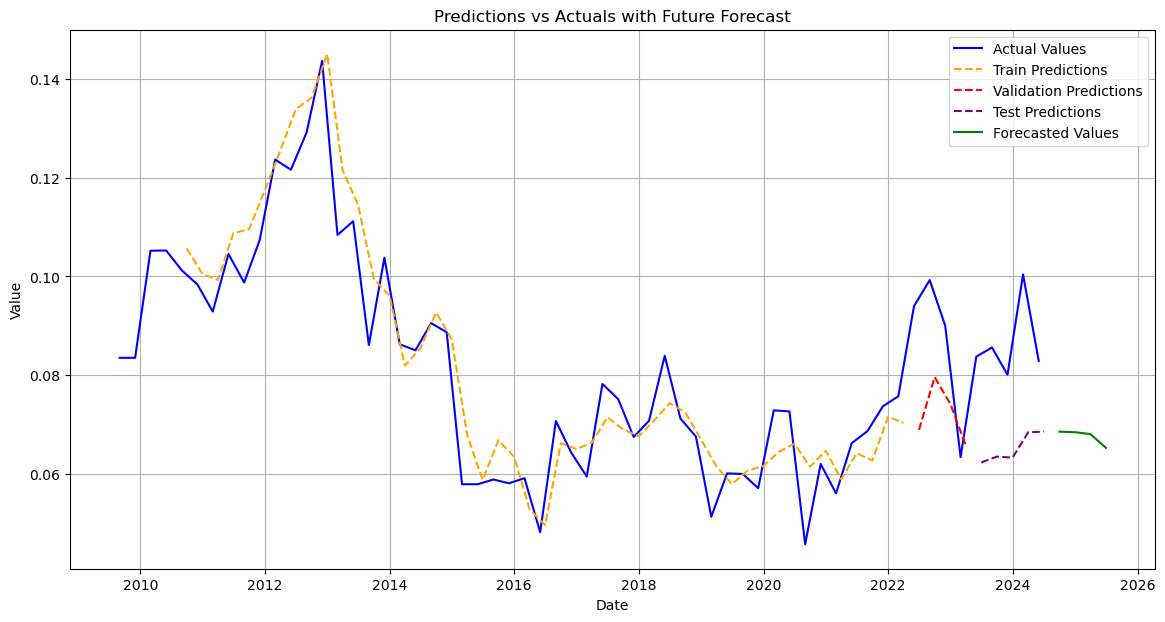

[[0.06857465]
 [0.06845436]
 [0.06807157]
 [0.06529422]]


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load data
data = pd.read_excel('/Users/ashleyyang/Desktop/acep/final_data/quarter.xlsx')
data['date'] = pd.to_datetime(data['date'])

# Initialize scalers
scalers = {
    'fpp_real': MinMaxScaler(),
    'effective_real': MinMaxScaler(),
    'nat_gas_real': MinMaxScaler(),
    'oil': MinMaxScaler(),
    'coal': MinMaxScaler(),
    'crude_oil_prod': MinMaxScaler(),
    'crude_prices_real': MinMaxScaler(),
    'net_gen': MinMaxScaler(),
    'wnd': MinMaxScaler(),
    'perc_change': MinMaxScaler()
}

# Scale features
scaled_features = {}
for feature in scalers.keys():
    scaled_features[f'{feature}_scaled'] = scalers[feature].fit_transform(data[[feature]])

# Convert scaled features to 1D arrays and create a DataFrame
for feature in scaled_features.keys():
    data[feature] = scaled_features[feature].flatten()

# Extract scaled features into a new DataFrame
data_scaled = data[[f'{feature}_scaled' for feature in scalers.keys()]]

# Target variable
scaled_fpp = data_scaled[['fpp_real_scaled']].values

# Create sequences
def create_sequences(data, seq_length=5):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

seq_length = 4
X, Y = create_sequences(data_scaled.values, seq_length=seq_length)

# Split data
split_date_train = '2022-06-01'
split_date_val = '2023-06-01'
split_index_train = data[data['date'] < split_date_train].shape[0] - seq_length
split_index_val = data[(data['date'] >= split_date_train) & (data['date'] < split_date_val)].shape[0] + split_index_train
split_index_train = max(split_index_train, 0)
split_index_val = min(split_index_val, X.shape[0])
X_train, Y_train = X[:split_index_train], Y[:split_index_train]
X_val, Y_val = X[split_index_train:split_index_val], Y[split_index_train:split_index_val]
X_test, Y_test = X[split_index_val:], Y[split_index_val:]

# Reshape data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build model
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, Y_train, batch_size=4, epochs=100, validation_data=(X_val, Y_val))

# Predict
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)
train_predictions = scalers['fpp_real'].inverse_transform(train_predictions.reshape(-1, 1))
val_predictions = scalers['fpp_real'].inverse_transform(val_predictions.reshape(-1, 1))
test_predictions = scalers['fpp_real'].inverse_transform(test_predictions.reshape(-1, 1))

# Inverse transform actual values
combined_actual_train = scalers['fpp_real'].inverse_transform(Y_train.reshape(-1, 1))
combined_actual_val = scalers['fpp_real'].inverse_transform(Y_val.reshape(-1, 1))
combined_actual_test = scalers['fpp_real'].inverse_transform(Y_test.reshape(-1, 1))

# Extend combined_actual_test to match the length of test dates
combined_actual_test = np.squeeze(combined_actual_test)
if len(combined_actual_test) < len(data['date'][split_index_val:]):
    combined_actual_test = np.pad(combined_actual_test, (0, len(data['date'][split_index_val:]) - len(combined_actual_test)), 'constant', constant_values=np.nan)
elif len(combined_actual_test) > len(data['date'][split_index_val:]):
    combined_actual_test = combined_actual_test[:len(data['date'][split_index_val:])]

# Forecast future values
def forecast_future(model, initial_sequence, num_steps, scaler):
    future_predictions = []
    current_sequence = initial_sequence

    for _ in range(num_steps):
        pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
        future_predictions.append(pred[0, 0])
        new_data_point = np.concatenate((pred, current_sequence[-1, 1:].reshape(1, -1)), axis=1)
        current_sequence = np.concatenate((current_sequence[1:], new_data_point), axis=0)

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Forecast future values
initial_sequence = X_test[-1]
num_steps = 4
future_predictions = forecast_future(model, initial_sequence, num_steps, scalers['fpp_real'])

# Extend the future dates for the forecasted values
last_date = data['date'].max()
future_dates = pd.date_range(start=last_date, periods=num_steps+1, freq='Q')[1:]

# Create corresponding date ranges for plotting
date_train_range = pd.date_range(start=data['date'].iloc[seq_length], periods=len(train_predictions), freq='Q')
date_val_range = pd.date_range(start=data['date'].iloc[len(train_predictions)+seq_length], periods=len(val_predictions), freq='Q')
date_test_range = pd.date_range(start=data['date'].iloc[len(train_predictions) + len(val_predictions) + seq_length], periods=len(test_predictions), freq='Q')

# Combine dates for train, validation, test, and future predictions
combined_dates = np.concatenate((date_train_range, date_val_range, date_test_range, future_dates))

# Combine predictions for train, validation, test, and future
combined_predictions = np.concatenate((train_predictions.flatten(), val_predictions.flatten(), test_predictions.flatten(), future_predictions.flatten()))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['fpp_real'], color='blue', label='Actual Values')
plt.plot(date_train_range, train_predictions.flatten(), color='orange', linestyle='dashed', label='Train Predictions')
plt.plot(date_val_range, val_predictions.flatten(), color='red', linestyle='dashed', label='Validation Predictions')
plt.plot(date_test_range, test_predictions.flatten(), color='purple', linestyle='dashed', label='Test Predictions')
plt.plot(future_dates, future_predictions.flatten(), color='green', label='Forecasted Values')
plt.title('Predictions vs Actuals with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions
print(future_predictions)


In [27]:

#print future predictions
print(future_predictions)
#get last value in data[cpi]
last_cpi = data['CPI_new'].iloc[-1]
for pred in future_predictions: 
    cpi_adj = []
    pred = ((pred/100)*last_cpi)
    print(pred)

score = model.evaluate(X_test, Y_test, verbose=1)


[[0.06857465]
 [0.06845436]
 [0.06807157]
 [0.06529422]]
[0.1135813]
[0.11338205]
[0.11274803]
[0.10814787]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0513


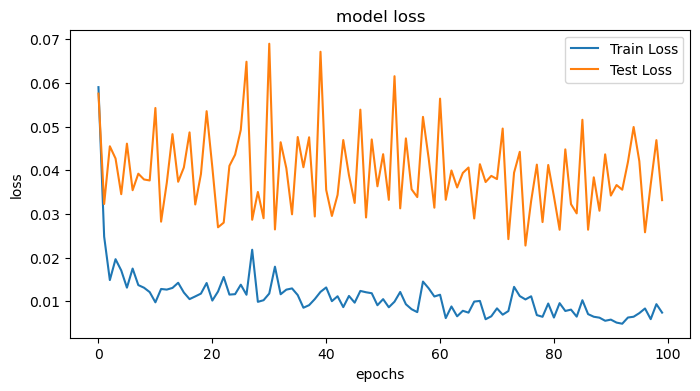

In [28]:
#plot rmse and loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

# Ensure lengths match for MAPE calculation
min_len_train = min(len(combined_actual_train), len(train_predictions))
min_len_val = min(len(combined_actual_val), len(val_predictions))
min_len_test = min(len(combined_actual_test), len(test_predictions))

train_mape = mean_absolute_percentage_error(combined_actual_train[:min_len_train], train_predictions[:min_len_train])
val_mape = mean_absolute_percentage_error(combined_actual_val[:min_len_val], val_predictions[:min_len_val])
test_mape = mean_absolute_percentage_error(combined_actual_test[:min_len_test], test_predictions[:min_len_test])

print(f'Train MAPE: {train_mape * 100:.2f}%')
print(f'Validation MAPE: {val_mape * 100:.2f}%')
print(f'Test MAPE: {test_mape * 100:.2f}%')


Train MAPE: 6.96%
Validation MAPE: 16.96%
Test MAPE: 24.29%
